In [115]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [116]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               788 non-null    object 
 1   SeasonNumber       788 non-null    int64  
 2   SeasonVersion      788 non-null    int64  
 3   Player             788 non-null    object 
 4   MatchId            788 non-null    object 
 5   Map                788 non-null    object 
 6   Category           788 non-null    object 
 7   Playlist           788 non-null    object 
 8   Input              788 non-null    object 
 9   Queue              788 non-null    object 
 10  PreCsr             788 non-null    int64  
 11  PostCsr            788 non-null    int64  
 12  Rank               788 non-null    int64  
 13  WasAtStart         788 non-null    int64  
 14  WasAtEnd           788 non-null    int64  
 15  WasInProgressJoin  788 non-null    int64  
 16  Mmr                2 non-n

In [117]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']

## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr', 'SeasonNumber', 'SeasonVersion'],axis=1)
dfr = df[df['Date']> '2023-01-01']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               542 non-null    int64         
 1   Date                542 non-null    datetime64[ns]
 2   Map                 542 non-null    object        
 3   Category            542 non-null    object        
 4   Rank                542 non-null    int64         
 5   Outcome             542 non-null    int64         
 6   Accuracy            542 non-null    float64       
 7   DamageDone          542 non-null    int64         
 8   DamageTaken         542 non-null    int64         
 9   ShotsFired          542 non-null    int64         
 10  ShotsLanded         542 non-null    int64         
 11  ShotsMissed         542 non-null    int64         
 12  KD                  542 non-null    float64       
 13  KDA                 542 non-null    float64       

In [118]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,542.0,464.928044,187.706875,140.000000,303.250000,462.500000,623.750000,787.000000
Rank,542.0,3.983395,2.166307,1.000000,2.000000,4.000000,5.000000,8.000000
Outcome,542.0,0.540590,0.498810,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,542.0,51.392269,5.294837,24.390000,48.390000,51.505000,54.417500,80.560000
DamageDone,542.0,5212.861624,1839.546898,347.000000,3864.000000,4971.500000,6433.250000,12673.000000
DamageTaken,542.0,4423.811808,1528.420902,35.000000,3448.250000,4249.500000,5396.750000,9962.000000
ShotsFired,542.0,236.431734,80.383174,16.000000,181.000000,228.000000,294.000000,517.000000
ShotsLanded,542.0,121.232472,42.443889,4.000000,94.000000,116.000000,149.750000,286.000000
ShotsMissed,542.0,115.199262,41.175664,7.000000,87.000000,112.000000,141.750000,261.000000
KD,542.0,1.280535,0.768370,0.000000,0.860000,1.130000,1.460000,10.000000


In [119]:
# dfr.tail()
# round(dfr.sort_values('LifetimeAcc', ascending=False),2)

In [120]:
# dfr.hist(bins=15, figsize=(18, 14))
# plt.tight_layout()
# plt.show()

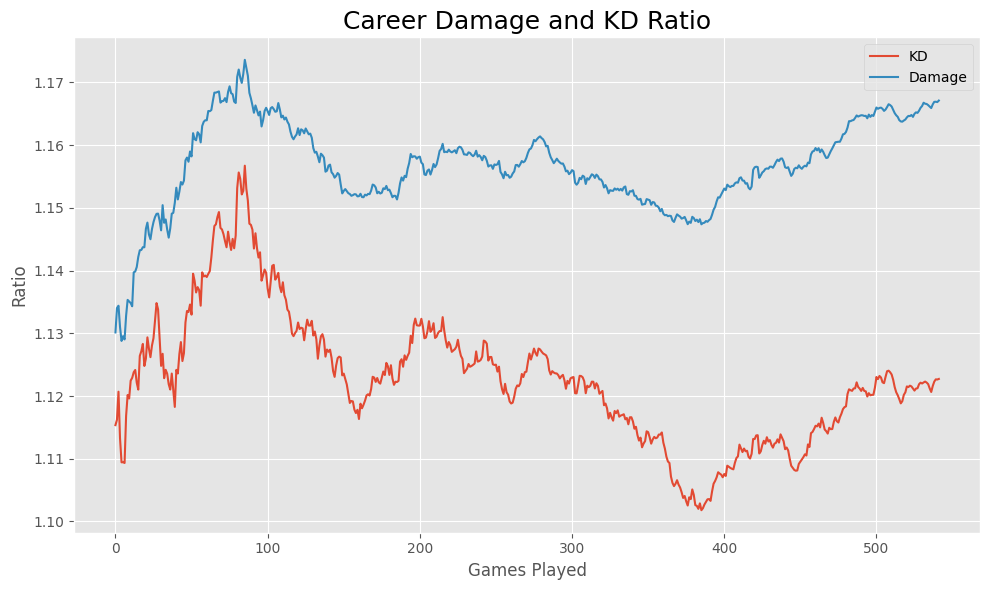

In [121]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Career Damage and KD Ratio', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/DamKD.png', dpi=300)
plt.show()

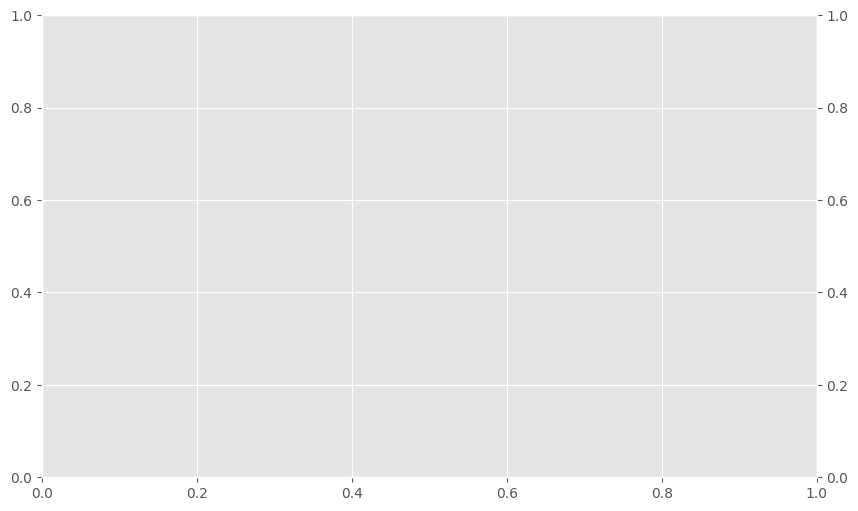

In [122]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams['animation.embed_limit'] = 300.0

dfr_date = dfr.index
dfr_kd = dfr['LifetimeKD']
dfr_dam = dfr['LifetimeDmgRatio']
dfr_csr = dfr['Csr']

# then assign df_date to x and df_close to y
x = dfr_date
y = dfr_kd
y2 = dfr_dam
y3 = dfr_csr

# calculate min and max x values + 1 and
# the min and max y values times scale factors
min_x = min(x)
max_x = max(x)
min_y = min(min(y), min(y2))
max_y = max(max(y), max(y2))
min_y3 = min(y3)
max_y3 = max(y3)

#########################################################################################
# generate and display animation line plot
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax2 = ax.twinx()

def animate(i):
    ax.cla() # clear the previous image
    ax2.cla()
    plt.title('KD/Damage Ratio and CSR over Time',fontsize=16)
    plt.xlabel('Game Played')
    plt.ylabel('Ratios/CSR')
    ax.plot(x[:i], y[:i], label='KD') # plot the line
    ax.plot(x[:i], y2[:i], label='Damage') # plot the line
    ax2.plot(x[:i], y3[:i], label='CSR', color='black')
    ax.set_xlim([0.99*min_x, 0.99*max_x]) # fix the x axis
    ax.set_ylim([0.99*min_y, 1.01*max_y]) # fix the y axis 
    ax2.set_xlim([0.99*min_x, 0.99*max_x])
    ax2.set_ylim(min_y3, 1.05*max_y3)
    ax.legend(loc='upper right')
#     ax2.legend(loc='lower right')
    
# anim = animation.FuncAnimation(fig, animate, frames = len(x), interval = 15)

# anim.save('Plots/KDDamCSR.gif', writer='imagemagick', fps=60)

# # Save the animation as HTML
# html_output = anim.to_html5_video()
# # Display the HTML animation in the Jupyter Notebook
# HTML(html_output)

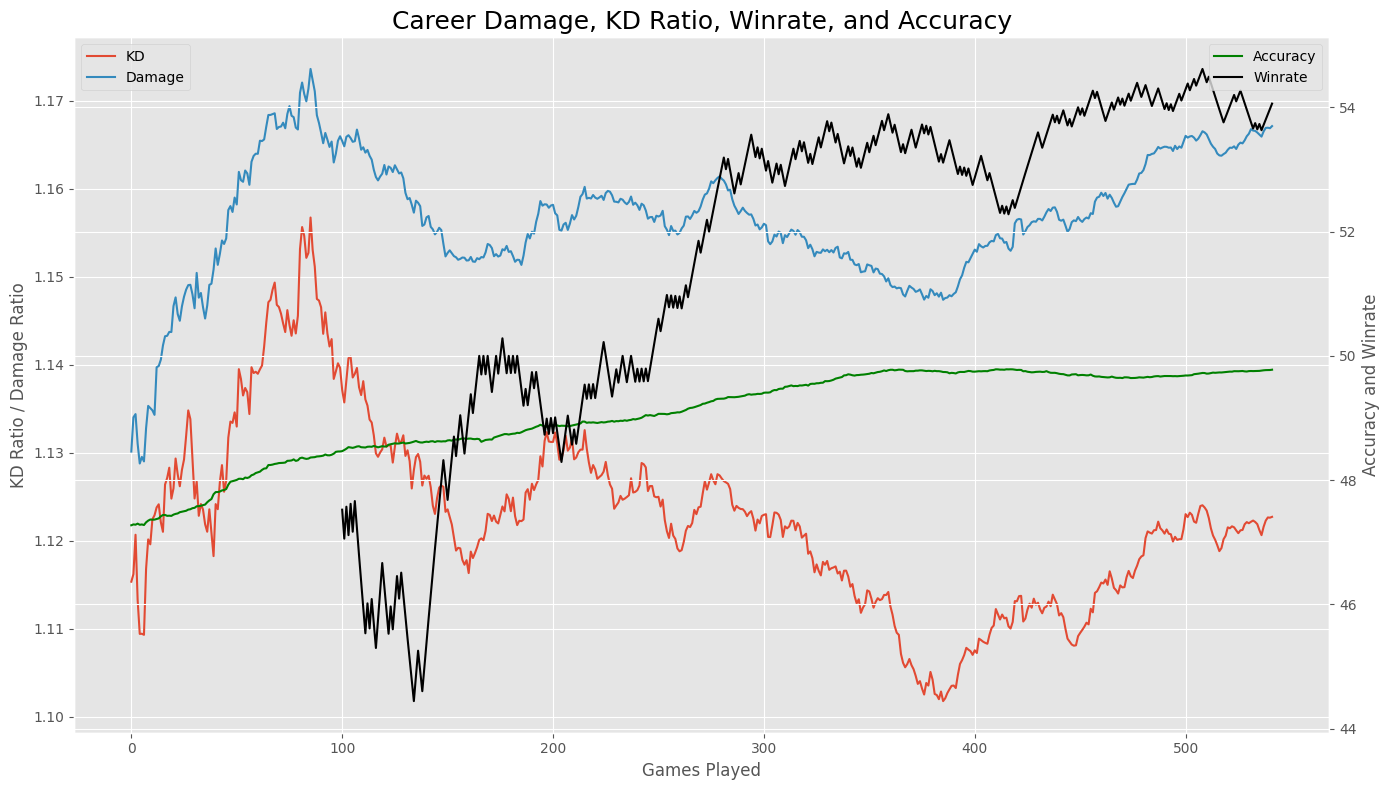

In [123]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax2.plot(dfr['LifetimeWinRate'][100:]*100, color='black', label='Winrate')
ax1.set_title('Career Damage, KD Ratio, Winrate, and Accuracy', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy and Winrate')

ax1.yaxis.grid(True)
ax2.yaxis.grid(True)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDWRAcc.png', dpi=300)
plt.show()

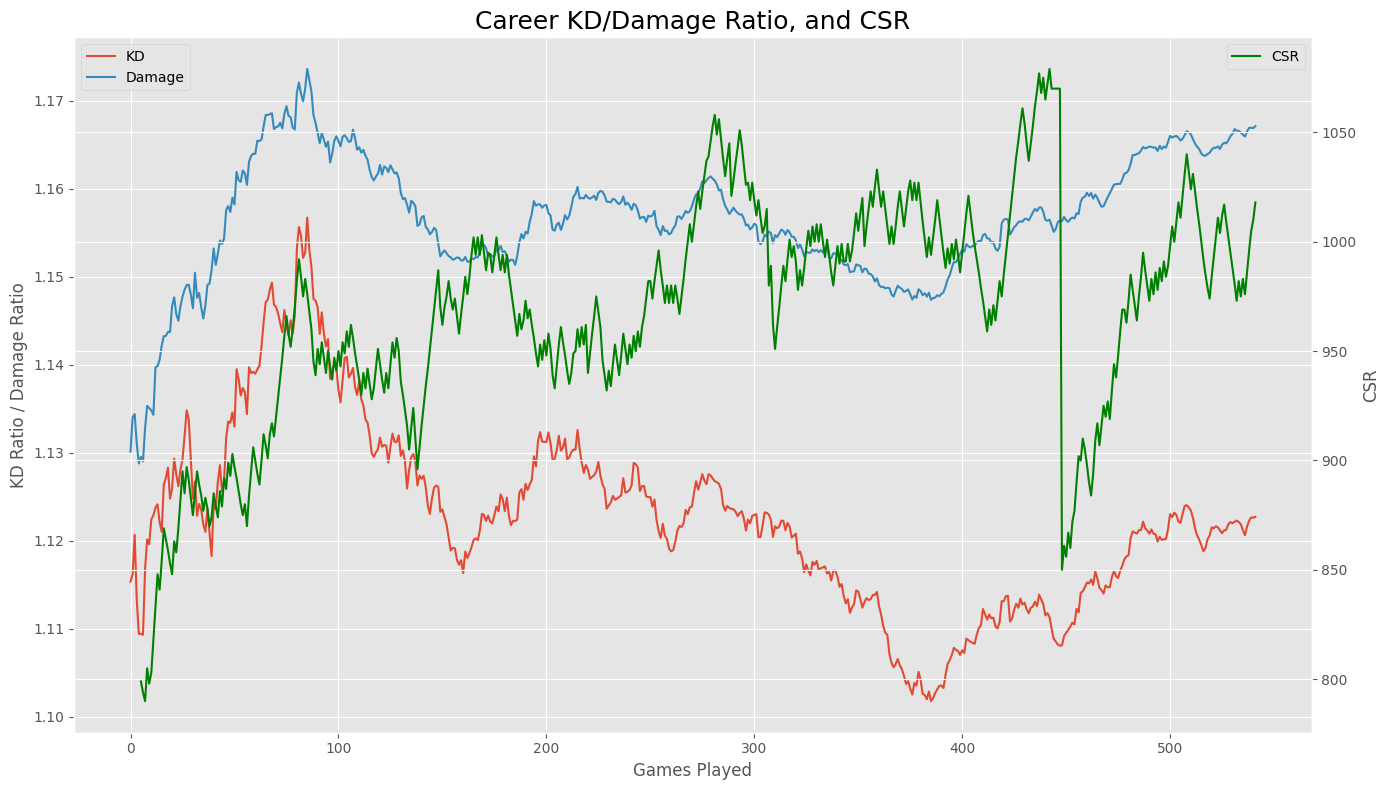

In [124]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'][5:], label='CSR', color='green')
ax1.set_title('Career KD/Damage Ratio, and CSR', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
# ax1.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDCsr.png', dpi=300)
plt.show()

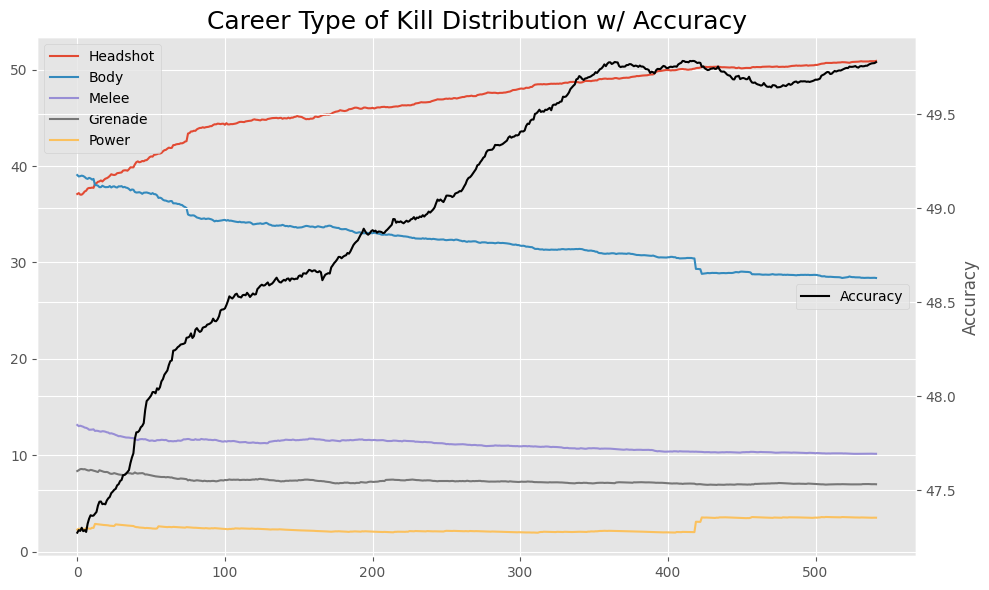

In [125]:
plt.figure(figsize=(10,6))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeHSPct'], label='Headshot')
ax1.plot(dfr['LifetimeBodyPct'], label='Body')
ax1.plot(dfr['LifetimeMeleePct'], label='Melee')
ax1.plot(dfr['LifetimeGrenadePct'], label='Grenade')
ax1.plot(dfr['LifetimePowerPct'], label='Power')
ax2.plot(dfr['LifetimeAcc'], label='Accuracy', color='black')
plt.title('Career Type of Kill Distribution w/ Accuracy', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Accuracy')
ax1.legend(loc='best')
ax2.legend(loc='right')
ax1.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/TypeKillAcc.png', dpi=300)
plt.show()

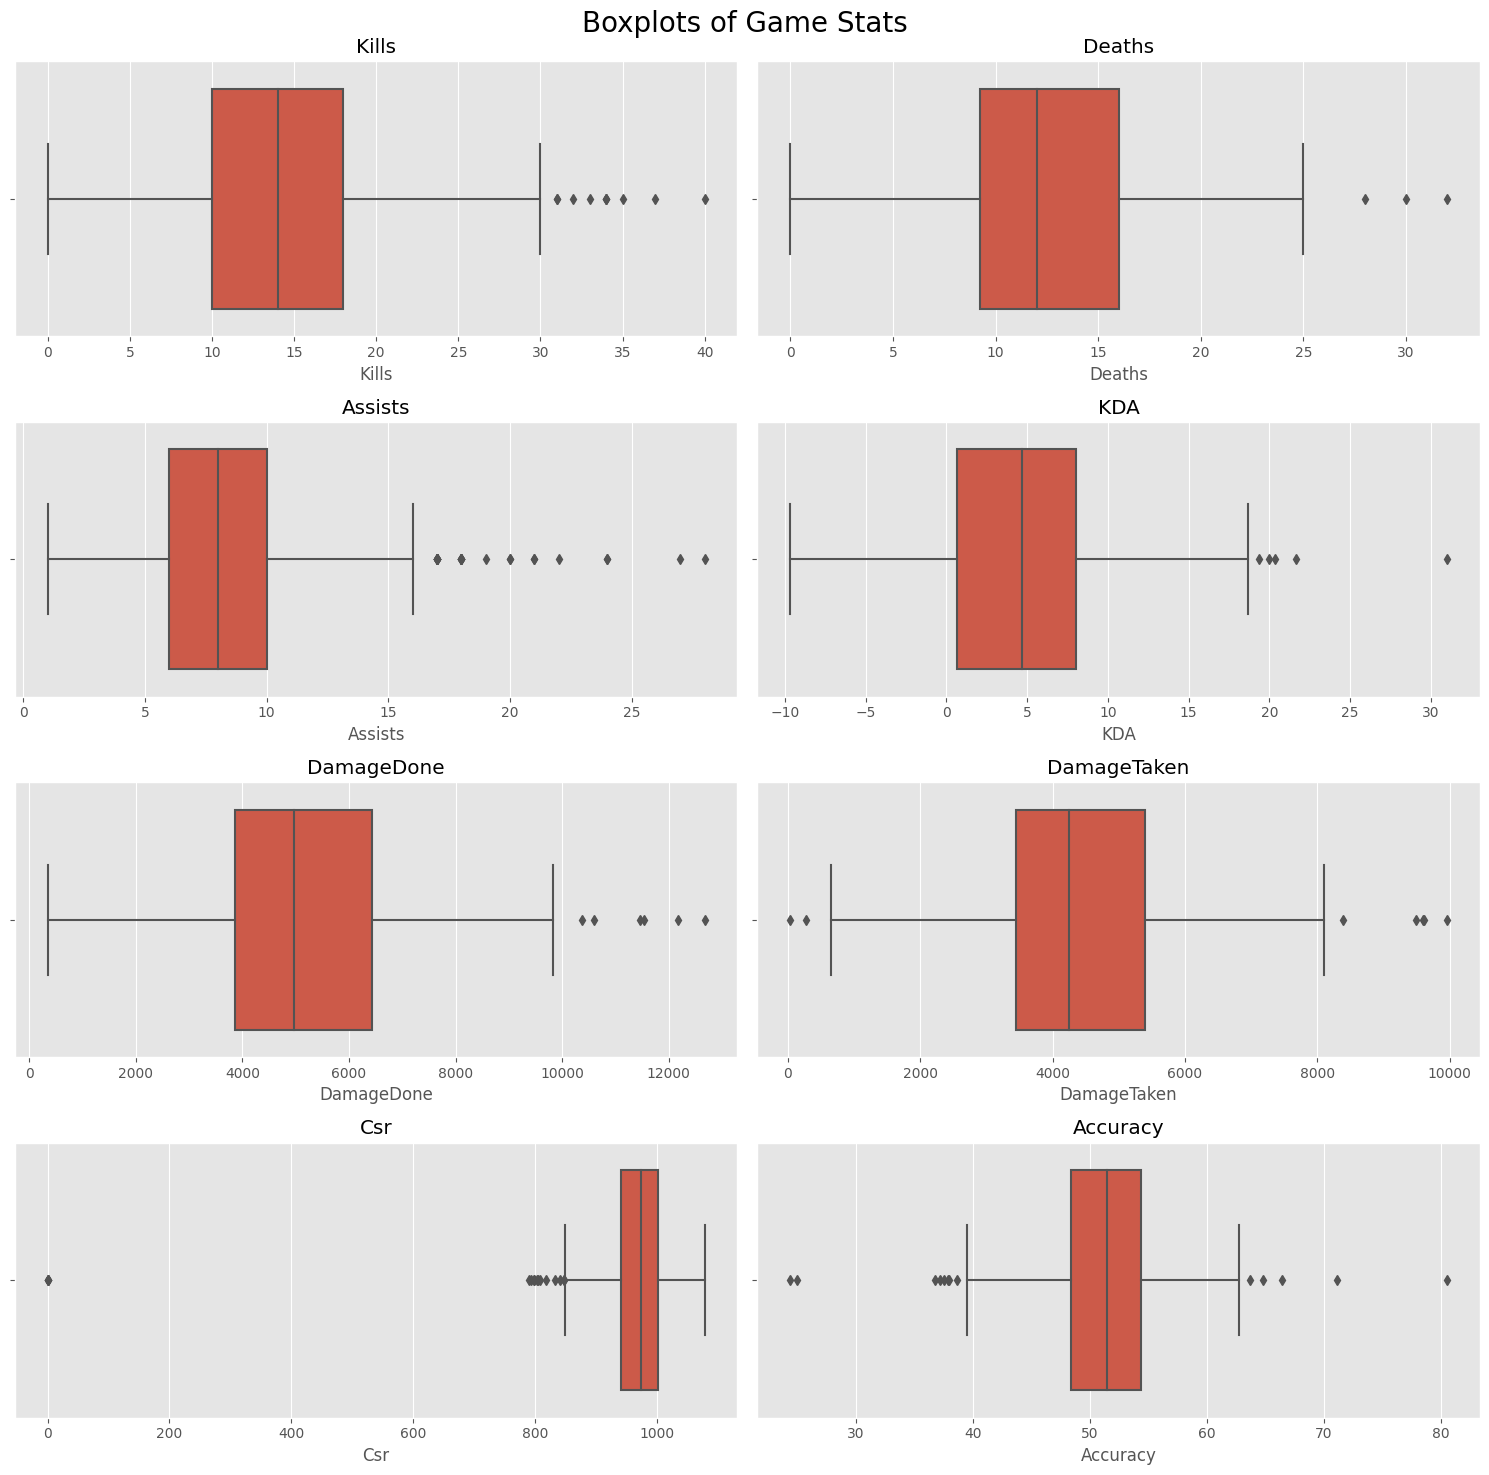

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=20)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


Last * Games stats  
Set mod to however many game you want to view 

In [127]:
# Last * Games

mod = 11
dfmod = dfr.tail(mod)

# dfmod = dfr[dfr['DamageTaken'] < dfr['DamageDone']]
# dfmod1 = dfr[dfr['DamageTaken'] > dfr['DamageDone']]

# print(dfmod.head())
print(f'Overall KD: {round(dfmod["Kills"].sum() / dfmod["Deaths"].sum(),2)}')
print(f"Accuracy: {round(dfmod['ShotsLanded'].sum() / dfmod['ShotsFired'].sum()*100,2)}")
print(f"Damage Ratio: {round(dfmod['DamageDone'].sum() / dfmod['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfmod['Outcome']==1).sum()}-{(dfmod['Outcome']==0).sum()}")
print(f"Winrate: {round((dfmod['Outcome']==1).sum() / (dfmod['Outcome']==0).sum() ,2)}")
print(f"Max CSR: {dfmod['Csr'].max()}")
# dfmod.sort_values('Kills', ascending=False).head(10)



Overall KD: 1.19
Accuracy: 52.01
Damage Ratio: 1.24
Win-Loss: 7-4
Winrate: 1.75
Max CSR: 1018


In [128]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

print('Overall')
print(f'Overall KD: {round(dfr["Kills/10Min"].sum() / dfr["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Dmg Done <> Taken: {len(dfmod)}-{len(dfmod1)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills/10Min"].sum() / dfw["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills/10Min"].sum() / dfl["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.15
Average Kills: 13.78
Average Deaths: 11.96
Average Assists: 7.96
Average Accuracy: 51.28
Average Damage Done: 5213
Average Damage Taken: 4424
Damage Ratio: 1.18
Dmg Done <> Taken: 11-119
Win-Loss: 293-249
----------------------------
Wins
Overall KD: 1.34
Average Kills: 14.31
Average Deaths: 10.69
Average Assists: 8.41
Average Accuracy: 51.48
Average Damage Done: 5050
Average Damage Taken: 4073
Damage Ratio: 1.24
Wins: 293
----------------------------
Losses
Overall KD: 0.98
Average Kills: 13.15
Average Deaths: 13.45
Average Assists: 7.42
Average Accuracy: 51.05
Average Damage Done: 5404
Average Damage Taken: 4836
Damage Ratio: 1.12
Losses: 249


In [129]:
# Ranks, 1 = Top Winner, 5 = Top Loser
g1 = dfr[dfr['Rank'] == 1].value_counts().count()
g5 = dfr[dfr['Rank'] == 5].value_counts().count()
g15 = round((g1 + g5) / len(dfr)*100,2)


print('Games Ranked 1:',g1)
print('Games Ranked 5:',g5)
print('MVP %:',g15 )

Games Ranked 1: 114
Games Ranked 5: 127
MVP %: 44.46


## Scorigami
Inspired by NFL, tracks unique statlines and counts if theyve occured before, only shows duplicate records instead of unique

In [130]:
# Create a new column for the combined score in the desired format
dfGami = pd.DataFrame()
dfGami['Kills'] = dfr['Kills']
dfGami['Deaths'] = dfr['Deaths']
dfGami['Assists'] = dfr['Assists']
dfGami['Scorigami'] = dfr['Kills'].astype(str) + '-' + dfr['Deaths'].astype(str) + '-' + dfr['Assists'].astype(str)

# Get unique scorigami scores
scorigami_list = dfGami['Scorigami'].unique()

dfGami = dfGami.sort_values(by=['Kills', 'Deaths', 'Assists'], ascending=False)
print(dfGami.head())
dfGami.to_csv('Scorigami.csv')

     Kills  Deaths  Assists Scorigami
80      40      17       24  40-17-24
310     37      28       17  37-28-17
338     35      25       18  35-25-18
103     34      23        7   34-23-7
392     34      21       15  34-21-15


In [131]:
gamiPiv = dfGami.pivot_table(index='Scorigami', aggfunc='size')

gamiPiv = gamiPiv.sort_index()

print("Records with >= 3 Scori:",gamiPiv[gamiPiv.values>2].count())
print(gamiPiv[gamiPiv.values>2].sort_values(ascending=False))


Records with >= 3 Scori: 5
Scorigami
15-8-7      3
19-18-10    3
6-11-8      3
7-12-7      3
8-11-5      3
dtype: int64


In [132]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
round(dfrc.sort_values('Length%', ascending=False),2)

,LengthMinutes,Count,Length%,Count%
Category,,,,
Slayer,1087.70,127,19.22,23.43
Strongholds,974.17,82,17.22,15.13
Oddball,913.62,77,16.15,14.21
CTF 3 Captures,892.03,81,15.77,14.94
King of the Hill,842.47,77,14.89,14.21
Extraction,611.85,70,10.81,12.92
CTF 5 Captures,336.27,28,5.94,5.17


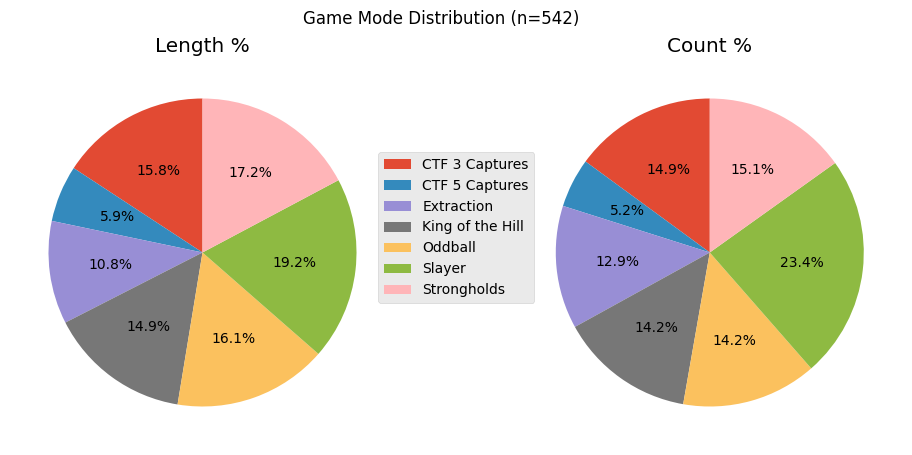

In [133]:
import matplotlib.pyplot as plt

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()
totalcount = dfrc['Count'].sum()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
fig.suptitle(f'Game Mode Distribution (n={totalcount})')
ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count %')
fig.legend(labels, loc="center")
plt.savefig('Plots/ModeDistro.png', dpi=300)
plt.show()

In [134]:
dfrc = dfr.groupby(['Category','Map']).agg({'Category': 'count', 'LengthMinutes': 'sum', 'Outcome': 'mean'})
dfrc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthHours']/60,2)
dfrc['Outcome'] = round(dfrc['Outcome'],2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['Length%'] = round(dfrc['LengthHours'] / dfrc['LengthHours'].sum() * 100,2)
dfrc = dfrc.sort_values(['Length%'], ascending=False)
dfrc

Count  LengthHours  Outcome  Count%  Length%
Category         Map                                                    
Strongholds      Solitude      38         7.99     0.42    7.01     8.47
King of the Hill Recharge      37         7.12     0.49    6.83     7.55
Oddball          Streets       31         6.34     0.58    5.72     6.72
CTF 3 Captures   Empyrean      31         5.98     0.42    5.72     6.34
CTF 5 Captures   Aquarius      28         5.60     0.50    5.17     5.94
Slayer           Solitude      37         5.40     0.59    6.83     5.73
                 Aquarius      38         5.39     0.55    7.01     5.72
CTF 3 Captures   Argyle        26         4.91     0.46    4.80     5.21
Oddball          Recharge      25         4.76     0.56    4.61     5.05
Extraction       Streets       33         4.74     0.61    6.09     5.03
Strongholds      Recharge      22         4.15     0.45    4.06     4.40
Oddball          Live Fire     21         4.13     0.62    3.87     4.38
Strongholds      Live Fire     22         4.09     0.50    4.06     4.34
CTF 3 Captures   Forbidden     24         3.98     0.62    4.43     4.22
King of the Hill Live Fire     22         3.50     0.77    4.06     3.71
                 Solitude      18         3.42     0.56    3.32     3.63
Slayer           Streets       21         2.80     0.62    3.87     2.97
Extraction       Recharge      18         2.76     0.61    3.32     2.93
Slayer           Live Fire     19         2.72     0.53    3.51     2.88
Extraction       Live Fire     19         2.70     0.42    3.51     2.86
Slayer           Recharge      12         1.83     0.58    2.21     1.94

In [135]:
dfrcc = dfr.groupby(['Category','Map']).agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'ShotsLanded' : 'sum',
                                             'ShotsFired' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             'LengthMinutes': 'sum',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) *100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min'] 
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
# dfrcc = round(dfrcc.sort_values(['Winrate', 'Accuracy'], ascending=False),2)
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

Count  Kills  Deaths  Assists  DamageDone  \
Category         Map                                                    
King of the Hill Live Fire     22    319     297      160      106859   
CTF 3 Captures   Forbidden     24    331     235      152      115053   
Oddball          Live Fire     21    326     324      220      124724   
Slayer           Streets       21    190     194      139       78718   
Extraction       Recharge      18    230     193      143       80159   
                 Streets       33    453     351      253      147191   
Slayer           Solitude      37    397     398      250      155125   
                 Recharge      12    112     114       82       48697   
Oddball          Streets       31    556     497      342      194626   
                 Recharge      25    394     333      244      144297   
King of the Hill Solitude      18    321     251      176      106652   
Slayer           Aquarius      38    397     381      243      155915   
                 Live Fire     19    194     182      102       70548   
CTF 5 Captures   Aquarius      28    539     402      257      182496   
Strongholds      Live Fire     22    358     291      148      120403   
King of the Hill Recharge      37    643     563      440      232346   
CTF 3 Captures   Argyle        26    377     321      180      136218   
Strongholds      Recharge      22    323     311      208      121319   
Extraction       Live Fire     19    230     216      125       82363   
Strongholds      Solitude      38    737     621      426      248563   
CTF 3 Captures   Empyrean      31    487     435      244      173099   

                            DamageTaken  Winrate  LengthMinutes  Accuracy  \
Category         Map                                                        
King of the Hill Live Fire        97129     0.77         210.20     53.50   
CTF 3 Captures   Forbidden        87494     0.62         238.83     51.66   
Oddball          Live Fire       105508     0.62         247.52     51.54   
Slayer           Streets          70157     0.62         167.70     48.59   
Extraction       Recharge         66596     0.61         165.43     51.43   
                 Streets         118482     0.61         284.25     54.27   
Slayer           Solitude        141432     0.59         323.97     49.82   
                 Recharge         44551     0.58         109.67     46.74   
Oddball          Streets         166942     0.58         380.43     53.42   
                 Recharge        118760     0.56         285.67     49.09   
King of the Hill Solitude         86382     0.56         205.05     51.35   
Slayer           Aquarius        138689     0.55         323.40     50.92   
                 Live Fire        66468     0.53         162.97     48.91   
CTF 5 Captures   Aquarius        141635     0.50         336.27     52.13   
Strongholds      Live Fire       105086     0.50         245.63     52.79   
King of the Hill Recharge        194087     0.49         427.22     50.25   
CTF 3 Captures   Argyle          110700     0.46         294.32     49.60   
Strongholds      Recharge        104449     0.45         248.95     48.40   
Extraction       Live Fire        72351     0.42         162.17     55.24   
Strongholds      Solitude        209641     0.42         479.58     52.86   
CTF 3 Captures   Empyrean        151167     0.42         358.88     51.15   

                              KD  DamageRatio  Dmg/Life  ExDmg/Life  \
Category         Map                                                  
King of the Hill Live Fire  1.07         1.10    359.79       32.76   
CTF 3 Captures   Forbidden  1.41         1.31    489.59      117.27   
Oddball          Live Fire  1.01         1.18    384.95       59.31   
Slayer           Streets    0.98         1.12    405.76       44.13   
Extraction       Recharge   1.19         1.20    415.33       70.27   
                 Streets    1.29         1.24    419.35       81.79   
Slayer  

In [136]:
dfrcc = dfr.groupby('Category').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Assists/Life', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,
King of the Hill,77,1283,1111,776,445857,377598,0.58,1.15,1.18,401.31,61.44,0.70
Oddball,77,1276,1154,806,463647,391210,0.58,1.11,1.19,401.77,62.77,0.70
Extraction,70,913,760,521,309713,257429,0.56,1.20,1.20,407.52,68.79,0.69
Slayer,127,1290,1269,816,509003,461297,0.57,1.02,1.10,401.11,37.59,0.64
Strongholds,82,1418,1223,782,490285,419176,0.45,1.16,1.17,400.89,58.14,0.64
CTF 5 Captures,28,539,402,257,182496,141635,0.50,1.34,1.29,453.97,101.64,0.64
CTF 3 Captures,81,1195,991,576,424370,349361,0.49,1.21,1.21,428.22,75.69,0.58


In [137]:
dfrcc = dfr.groupby('Map').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Assists/Life', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,
Recharge,114,1702,1514,1117,626818,528443,0.53,1.12,1.19,414.01,64.98,0.74
Streets,85,1199,1042,734,420535,355581,0.60,1.15,1.18,403.58,62.34,0.70
Solitude,93,1455,1270,852,510340,437455,0.52,1.15,1.17,401.84,57.39,0.67
Forbidden,24,331,235,152,115053,87494,0.62,1.41,1.31,489.59,117.27,0.65
Aquarius,66,936,783,500,338411,280324,0.53,1.20,1.21,432.20,74.19,0.64
Live Fire,103,1427,1310,755,504897,446542,0.57,1.09,1.13,385.42,44.55,0.58
Empyrean,31,487,435,244,173099,151167,0.42,1.12,1.15,397.93,50.42,0.56
Argyle,26,377,321,180,136218,110700,0.46,1.17,1.23,424.36,79.50,0.56


In [138]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 5.235992666101083s
